Импорт библиотек

In [51]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score

Всего датасет содержит 159 записей. Мы предварительно зарезервировали часть датасета для задания по преодолению бейслайна (baseline). В настоящем задании подразумевается работа с датасетом, содержащим 119 записей.

# 0. Применение полиномиальной регрессии для предсказания непрерывного параметра

Представленный набор данных — это набор данных о семи различных типах рыб, продаваемых в некоторой рыбной лавке. Наша цель заключается в том, чтобы предсказать массу рыбы по каким-то косвенным признакам, известным о рыбе. Сами признаки, быть может, нужно синтезировать из тех, что известны.

In [2]:
df = pd.read_csv('fish_train.csv')
train_1, test_1 = train_test_split(df,
                               test_size=0.2,
                               random_state=23,
                               stratify=df['Species'])
train: pd.DataFrame = train_1.drop(columns=['Species'])
test: pd.DataFrame = test_1.drop(columns=['Species'])

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки с параметрами, указанными в вашем задании. Используйте стратификацию по колонке <code>Species</code>. Стратификация позволит сохранить доли представленных объектов (по представителям типов рыб) в тренировочной и тестовой выборках.

Вычислите выборочное среднее колонки <code>Width</code> полученной тренировочной выборки.

In [3]:
train['Width'].mean()

4.448602105263158

# 1. Построение базовой модели

Избавьтесь от категориальных признаков и обучите модель линейной регрессии (<code>LinearRegression()</code>) на тренировочном наборе данных. Выполните предсказания для тестового набора данных. Оцените модель при помощи метрики <code>r2_score()</code>.

In [75]:
train_x, train_y = train.loc[:, 'Length1':'Width'], train.loc[:, 'Weight']
test_x, test_y = test.loc[:, 'Length1':'Width'], test.loc[:, 'Weight']
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)
y_pred = lin_reg.predict(test_x)

NameError: name 'train' is not defined

In [5]:
r2_score(test_y, y_pred)

0.8885408749541969

# 2. Добавление предварительной обработки признаков.

## Использование PCA

При помощи, например, <code>sns.heatmap()</code>, постройте матрицу корреляций признаков тренировочного набора данных и определите тройку наиболее коррелированных между собой признаков.

<Axes: >

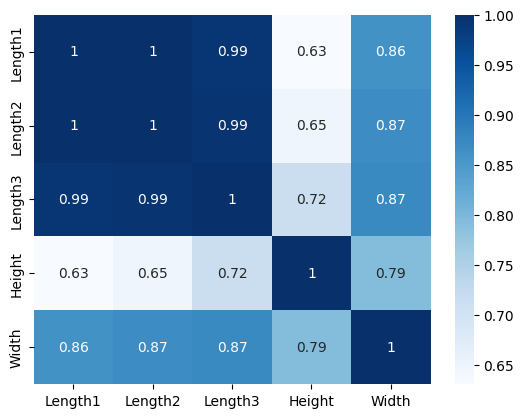

In [5]:
sns.heatmap(train_x.corr(numeric_only=True), annot=True, cmap='Blues')

Линейные модели достаточно плохо реагируют на коррелированные признаки, поэтому от таких признаков имеет смысл избавиться еще до начала обучения.

Для уменьшения количества неинформативных измерений используйте метод главных компонент. 

1) Примените метод главных компонент (<code>PCA(n_components=3, svd_solver='full')</code>) для трех найденных наиболее коррелированных признаков. 

2) Вычислите долю объясненной дисперсии при использовании только первой главной компоненты. 

3) Замените три наиболее коррелированных признака на новый признак <code>Lengths</code>, значения которого совпадают со значениями счетов первой главной компоненты.

In [6]:
train_x_len = train_x.loc[:, 'Length1':'Length3']

pca = PCA(n_components=3, svd_solver='full')
transformed = pca.fit_transform(train_x_len)

train_x['Lengths'] = transformed[:,0]
train_x = train_x.drop(columns=['Length1', 'Length2', 'Length3'])

Примените полученное преобразование для тех же признаков в тестовом наборе данных. Обратите внимание, что заново обучать преобразование `PCA` не нужно. Аналогично предыдущему этапу замените три рассмотренных признака на один.

In [7]:
test_x_len = test_x.loc[:, 'Length1':'Length3']

transformed_test = pca.transform(test_x_len)
test_x['Lengths'] = transformed_test[:, 0]
test_x = test_x.drop(columns=['Length1', 'Length2', 'Length3'])

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи <code>r2_score()</code>.

In [8]:
lin_reg.fit(train_x, train_y)
y_pred = lin_reg.predict(test_x)
r2_score(test_y, y_pred)

0.8925481416058358

Видно, что точность значительно не изменилась.

## Модификация признаков

Постройте графики зависимостей признаков от целевой переменной, например, при помощи <code>sns.pairplot()</code>.

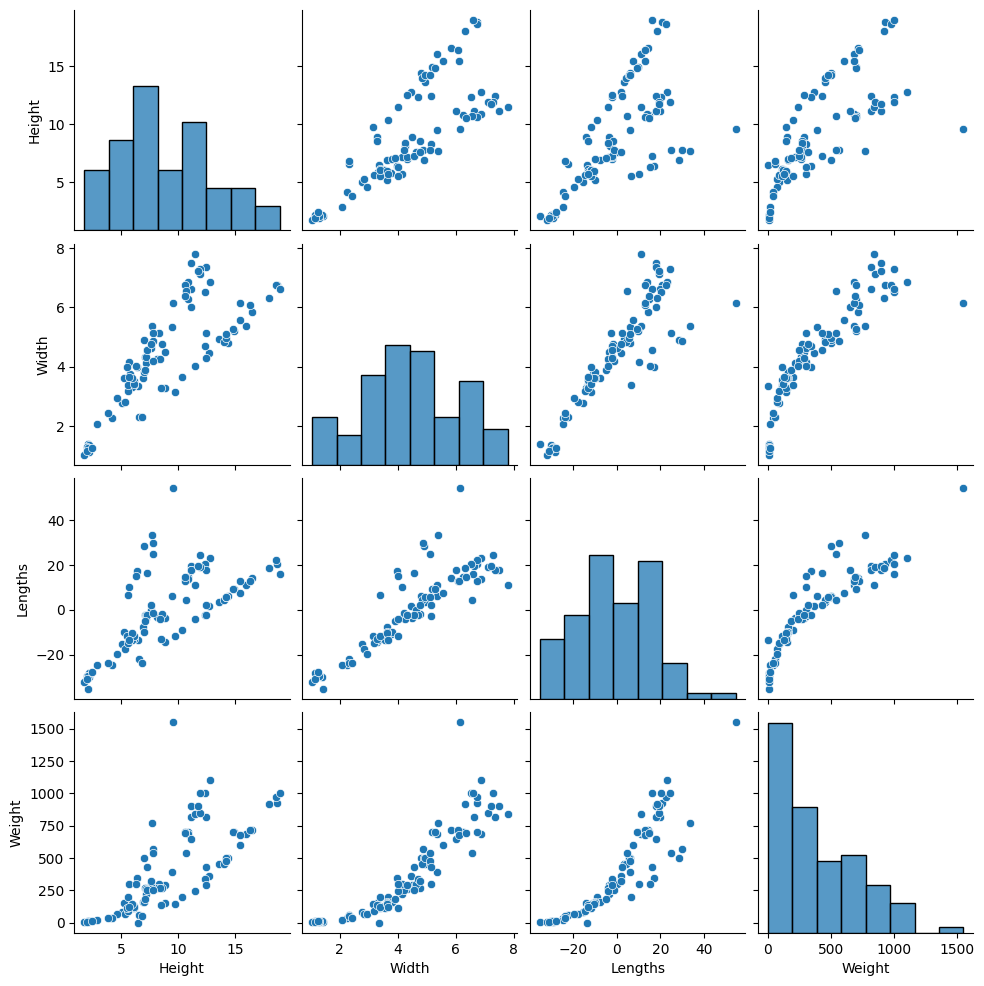

In [10]:
sns.pairplot(pd.concat([train_x, train_y], axis=1))

Видно, что масса, вообще говоря, нелинейно зависит от остальных параметров. Значит, чтобы линейная модель хорошо справлялась с предсказанием, признаки имеет смысл преобразовать так, чтобы зависимость стала более похожей на линейную. Но как придумать такую зависимость?

Логично предположить, что масса рыбы должна каким-то гладким образом зависеть от остальных параметров, отвечающих так или иначе за размеры. Если впомнить, что масса — это произведение плотности на объем, то

$$
m = \rho \cdot V.
$$

Допустим, что средняя плотность у всех рыб одинаковая, и вспомним, что при гомотетии объем объекта зависит от линейных размеров как куб, тогда получим

$$
m\sim V\sim d^3
$$

Все признаки тренировочного и тестового наборов данных, отвечающие так или иначе за размеры (<code>Height, Width, Lengths</code>), возведите в третью степень, и проверьте, стала ли зависимость массы от этих признаков похожа на линейную.

In [9]:
train_x['Height'] = train_x['Height'] ** 3
train_x['Width'] = train_x['Width'] ** 3
train_x['Lengths'] = train_x['Lengths'] ** 3

test_x['Height'] = test_x['Height'] ** 3
test_x['Width'] = test_x['Width'] ** 3
test_x['Lengths'] = test_x['Lengths'] ** 3

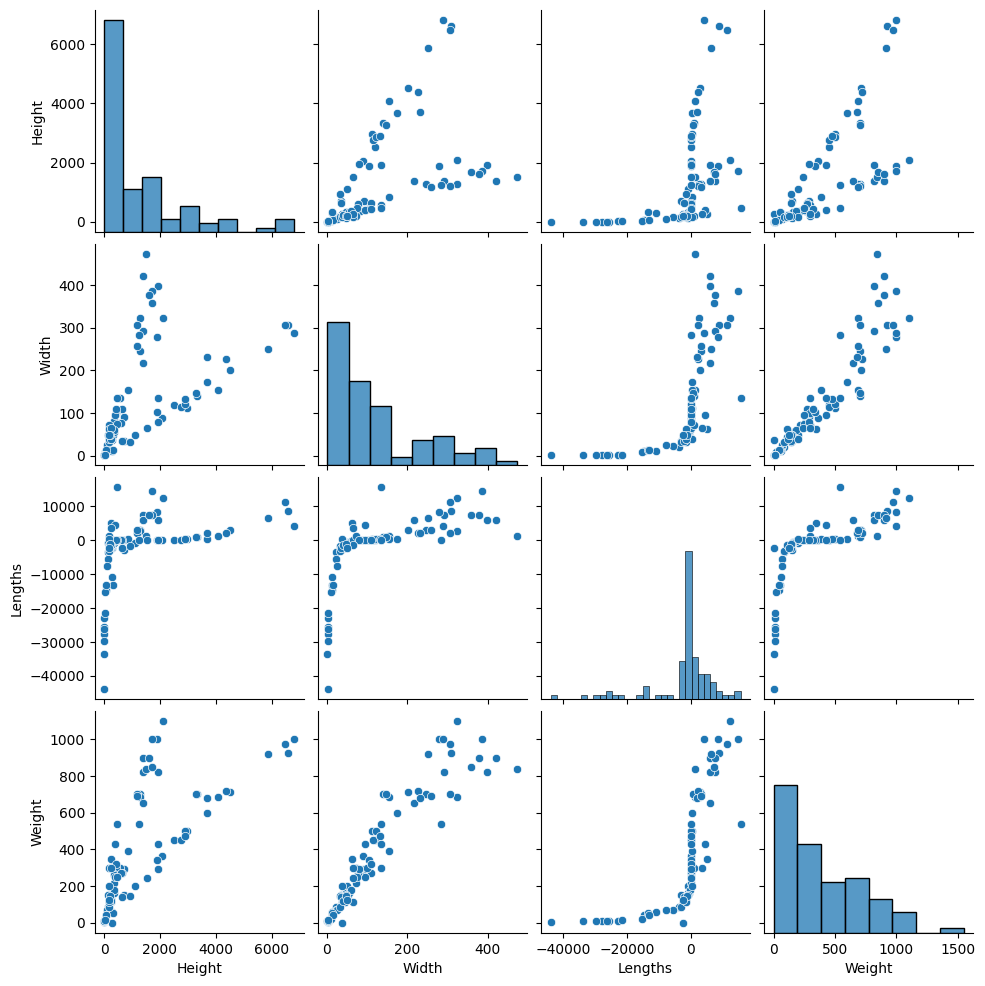

In [11]:
# df[ (df['Fee'] >= 22000) & (df['Discount'] == 2300)]
train_x = train_x[ (train_x['Lengths'] <= 20000) ] # & (train_x['Weight'] <= 1250)


df_to_visualise = pd.concat([train_x, train_y], axis=1)
# df_to_visualise = df_to_visualise[ (df_to_visualise['Lengths'] <= 20000) & (df_to_visualise['Weight'] <= 1250) ]
sns.pairplot(df_to_visualise)

Введите выборочное среднее колонки <code>Width</code> тренировочного набора данных после возведения в куб.

In [12]:
train_x['Width'].mean()

123.07234793468368

Выберите изображения, соответствующие зависимости <code>Weight</code> от <code>Width</code> до преобразования и после.

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи `r2_score()`.

In [14]:
lin_reg.fit(train_x, train_y)
y_pred = lin_reg.predict(test_x)
r2_score(test_y, y_pred)

0.9452890309259311

In [32]:
is_drop_first = True # поменять только тут

train_x_categs = train_x.join(train_1.loc[:,'Species'], how='left')
train_x_categs = pd.get_dummies(train_x_categs,
                                drop_first=is_drop_first,
                                columns=['Species'])


test_x_categs = test_x.join(test_1.loc[:,'Species'], how='left')
test_x_categs = pd.get_dummies(test_x_categs,
                               drop_first=is_drop_first,
                               columns=['Species'])

lin_reg.fit(train_x_categs, train_y)
y_pred = lin_reg.predict(test_x_categs)
r2_score(test_y, y_pred)

0.9525713724639544

----

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [16]:
train_df = (
    pd
    .read_csv('fish_train.csv')
    .iloc[:, [0,2,3,4,5,6,1]]
)
# train_df = pd.get_dummies(train_df, columns=['Species'])

# train_x, train_y = train_df.loc[:, 'Species':'Width'], train_df.loc[:, 'Weight']
test_x = (
    pd
    .read_csv('fish_reserved.csv')
    .loc[:, ['Species','Length1','Length2','Length3','Height','Width']]
)
test_x = pd.get_dummies(test_x, columns=['Species'])

In [17]:
train_df, test_df = train_test_split(train_df,
                                     test_size=0.2,
                                     random_state=23,
                                     stratify=train_df['Species'])
train_df = train_df.drop([82])

# train_df = pd.get_dummies(train_df, columns=['Species'], drop_first=True)
# test_df = pd.get_dummies(test_df, columns=['Species'], drop_first=True)

pca = PCA(n_components=3, svd_solver='full')

len_transformed = pca.fit_transform(train_df.loc[:,'Length1':'Length3'])
train_df['Lengths'] = len_transformed[:, 0]
train_df: pd.DataFrame = train_df.drop(columns=['Length1', 'Length2', 'Length3'])

len_transformed = pca.transform(test_df.loc[:,'Length1':'Length3'])
test_df['Lengths'] = len_transformed[:, 0]
test_df = test_df.drop(columns=['Length1', 'Length2', 'Length3'])

train_df['Volume'] = train_df['Height'] * train_df['Lengths'] * train_df['Width']
test_df['Volume'] = test_df['Height'] * test_df['Lengths'] * test_df['Width']

for col in ['Height', 'Lengths', 'Width']:
    train_df[col] = train_df[col] ** 3
    test_df[col] = test_df[col] ** 3

train_x, train_y = train_df.drop(columns=['Weight']), train_df.loc[:, 'Weight']
test_x, test_y = test_df.drop(columns=['Weight']), test_df.loc[:, 'Weight']

In [12]:
train_x.head()

,Species,Height,Width,Lengths,Volume
84,Smelt,10.712016,1.514536,21508.420417,70.402232
32,Roach,699.470343,90.930738,30.150590,124.239190
3,Bream,6596.227555,307.505871,-9457.188596,-2676.930095
24,Bream,2968.227824,111.604225,-289.345232,-457.647821
47,Bream,2062.933417,88.448270,-15.778043,-142.257739


In [18]:
scaler = StandardScaler()
a = scaler.fit_transform(train_x.drop(columns=['Species']))
train_x['Height'] = a[:,0]
train_x['Width'] = a[:,1]
train_x['Lengths'] = a[:,2]
train_x['Volume'] = a[:,3]

a = scaler.transform(test_x.drop(columns=['Species']))
test_x['Height'] = a[:,0]
test_x['Width'] = a[:,1]
test_x['Lengths'] = a[:,2]
test_x['Volume'] = a[:,3]

In [19]:
train_x

,Species,Height,Width,Lengths,Volume
84,Smelt,-0.790257,-1.064552,1.864587,0.605130
32,Roach,-0.348255,-0.282784,-0.051240,0.673357
3,Bream,3.435916,1.610738,-0.897496,-2.876504
24,Bream,1.107692,-0.102035,-0.079739,-0.064056
47,Bream,0.526730,-0.304488,-0.055337,0.335631
...,...,...,...,...,...
60,Pike,-0.494231,0.102289,-1.541045,-0.777090
112,Perch,-0.038917,1.178442,-0.362886,-0.774628
42,Perch,-0.661735,-0.659596,0.031934,0.786316
63,Perch,-0.678755,-0.646501,0.133686,0.854897


In [22]:
pca.explained_variance_ratio_.cumsum()* 100

array([ 70.39001528,  87.72480878,  97.23114745, 100.        ])

In [21]:
pca = PCA(svd_solver='full')

transformed = pca.fit_transform(train_x.loc[:,'Height':'Volume'])
train_x['Data_compressed_1'] = transformed[:,0]
train_x['Data_compressed_2'] = transformed[:,1]
train_x['Data_compressed_3'] = transformed[:,2]
train_x = train_x.drop(columns=['Height', 'Volume', 'Width', 'Lengths'])

transformed = pca.transform(test_x.loc[:,'Height':'Volume'])
test_x['Data_compressed_1'] = transformed[:,0]
test_x['Data_compressed_2'] = transformed[:,1]
test_x['Data_compressed_3'] = transformed[:,2]
test_x = test_x.drop(columns=['Height', 'Volume', 'Width', 'Lengths'])

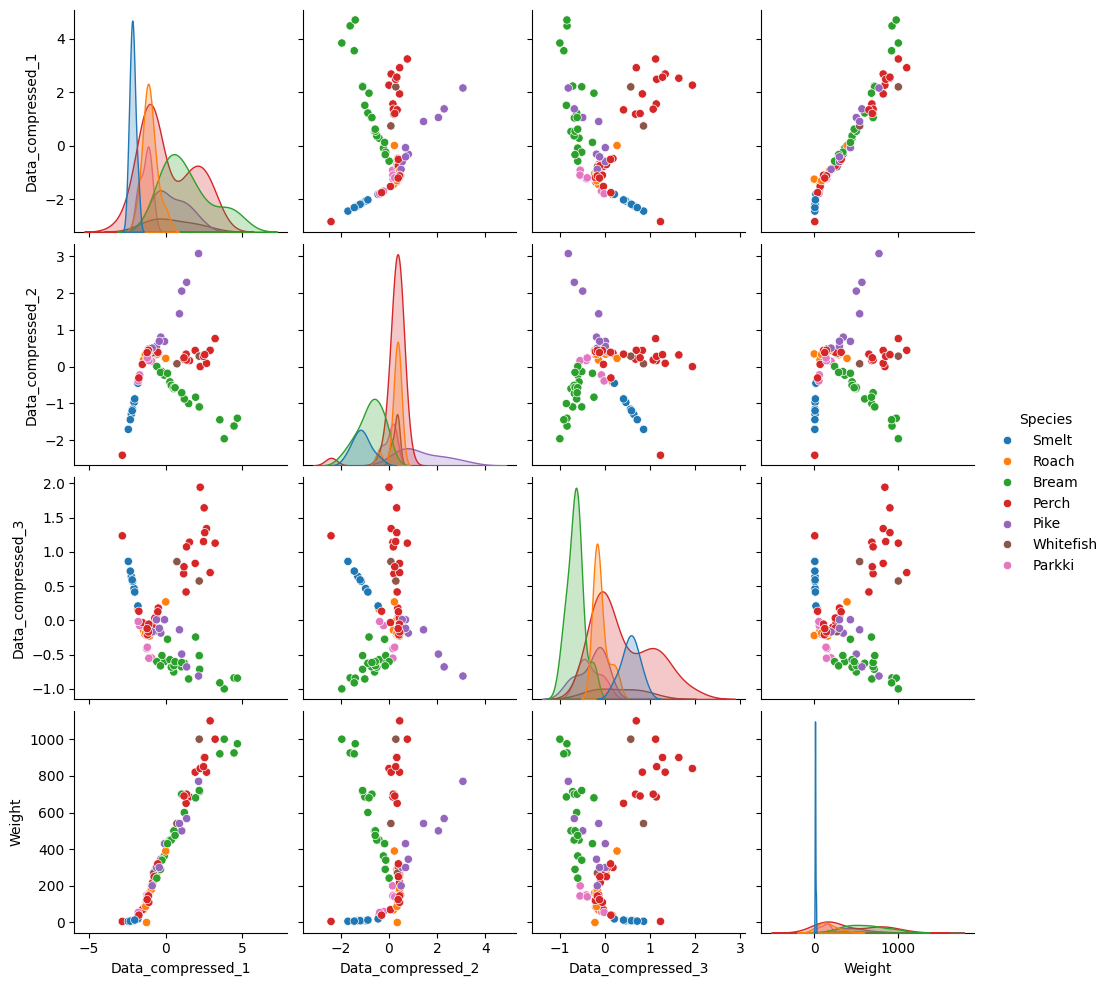

In [23]:
vis = train_x.join(train_df.loc[:,'Weight'], how='left')
sns.pairplot(vis, hue='Species')

In [24]:
train_x = pd.get_dummies(train_x, drop_first=True, columns=['Species'])
test_x = pd.get_dummies(test_x, drop_first=True, columns=['Species'])

In [26]:
# lin_reg = LinearRegression()
lin_reg = ElasticNet()
lin_reg.fit(train_x, train_y)
pred = lin_reg.predict(test_x)

r2_score(test_y, pred)

0.9446604202957833

In [70]:
train_df, test_df = train_test_split(train_df,
                                     test_size=0.2,
                                     random_state=23,
                                     stratify=train_df['Species'])

pca = PCA(n_components=3, svd_solver='full')

len_transformed = pca.fit_transform(train_df.loc[:,'Length1':'Length3'])
train_df['Lengths'] = len_transformed[:, 0]
train_df = train_df.drop(columns=['Length1', 'Length2', 'Length3'])

len_transformed = pca.transform(test_df.loc[:,'Length1':'Length3'])
test_df['Lengths'] = len_transformed[:, 0]
test_df = test_df.drop(columns=['Length1', 'Length2', 'Length3'])

poly = PolynomialFeatures(3)
train_df = poly.fit_transform(train_df.drop(columns=['Weight', 'Species']))
test_df = poly.fit(test_df.drop(columns=['Weight', 'Species']))

# for col in ['Height', 'Lengths', 'Width']:
#     train_df[col] = train_df[col] ** 3
#     test_df[col] = test_df[col] ** 3

# train_df = train_df[ train_df['Lengths'] < 20000 ]
# train_df = train_df[ ~((train_df['Lengths'] >= 10000) & (train_df['Width'] < 200)) ]

















# train_df = train_df[ ~((train_df['Lengths'] >= 10000) & (train_df['Height'] < 3000)) ]
# train_df = train_df.drop([105])
# train_df = train_df.drop([15])

# train_df = pd.get_dummies(train_df, columns=['Species'])
# test_df = pd.get_dummies(test_df, columns=['Species'])

In [37]:
# !!! ДЛЯ ВСЕГО ДАТАСЕТА

pca = PCA(n_components=3, svd_solver='full')

len_transformed = pca.fit_transform(train_df.loc[:,'Length1':'Length3'])
train_df['Lengths'] = len_transformed[:, 0]
train_df = train_df.drop(columns=['Length1', 'Length2', 'Length3'])

len_transformed = pca.transform(test_x.loc[:,'Length1':'Length3'])
test_x['Lengths'] = len_transformed[:, 0]
test_x = test_x.drop(columns=['Length1', 'Length2', 'Length3'])

for col in ['Height', 'Lengths', 'Width']:
    train_df[col] = train_df[col] ** 3
    test_x[col] = test_x[col] ** 3

train_df = train_df[ train_df['Lengths'] < 20000 ]
train_df = train_df[ ~((train_df['Lengths'] >= 10000) & (train_df['Width'] < 200)) ]

train_df = pd.get_dummies(train_df, columns=['Species'])
test_x = pd.get_dummies(test_x, columns=['Species'])

In [54]:
train_df = pd.get_dummies(train_df, drop_first=True, columns=['Species'])
test_df = pd.get_dummies(test_df, drop_first=True, columns=['Species'])

In [56]:
# lin_reg = LinearRegression()
lin_reg = ElasticNet()
X = train_df.drop(columns=['Weight'])
Y = train_df.loc[:,'Weight']
lin_reg.fit(X, Y)
pred = lin_reg.predict(test_df.drop(columns=['Weight']))

r2_score(test_df.loc[:,'Weight'], pred)

0.9519678850957092

In [55]:
lin_reg = LinearRegression()
# lin_reg = ElasticNet()
X = train_df.drop(columns=['Weight'])
Y = train_df.loc[:,'Weight']
lin_reg.fit(X, Y)
pred = lin_reg.predict(test_x)

In [54]:
with open('output.txt', 'wt') as output:
    string = ', '.join([str(a) for a in list(pred)])
    output.write(string)

Обратите внимание на то, как такая нехитрая работа с признаками помогла разительно улучшить точность модели!

## Добавление категориальных признаков

Произведите <code>one-hot</code> кодировние категориального признака `Species`, например, с помощью <code>pd.get_dummies()</code>.

Обучите модель линейной регресси на полученных тренировочных данных. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

<b>Примечание</b>: Мы специально использовали стратифицированное разделение, чтобы все значения категориального признака <code>Species</code> присутствовали во всех наборах данных. Но такое возможно не всегда. Про то, как с этим бороться можно почитать, [например, здесь](https://predictivehacks.com/?all-tips=how-to-deal-with-get_dummies-in-train-and-test-dataset).

И снова точность возрасла.

Как можно увидеть, после `one-hot` кодирования признаки стали коррелированы. От этого можно избавиться, например, при помощи параметра `drop_first=True`. Заново обучите модель после исправления этого недочета. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

На таком сравнительно небольшом наборе данных, впрочем, разницы мы не видим.